In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import umbra
from wifa_uq.postprocessing.bayesian_calibration import BayesianCalibration

CASE = "staggered_DX5D_DY5D_Turbine_NumberNumber25"
system_yaml = (
    str(Path.cwd())
    + "/data/farm_simulations/windio_Farm_ABL_IEA15/wind_energy_system/"
    + f"system_{CASE}.yaml"
)

# Bayesian UQ via WIFA-UQ
In this example, we calibrate the wake expansion rate of a wake model with quantified uncertainty via Bayesian UQ. The
- wake model is available via the Wind Farm API (WIFA), and the
- Bayesian UQ framework is implemented in the Uncertainty Modeling toolbox for Bayesian ReAnalysis (UMBRA).

Both libraries are called through WIFA-UQ. 

### Demonstration with artificial measurements

Get the flow model

In [2]:
fm = umbra.flow_model.WIFAModel(open(system_yaml))
fm.name_model

'Bastankhah2014'

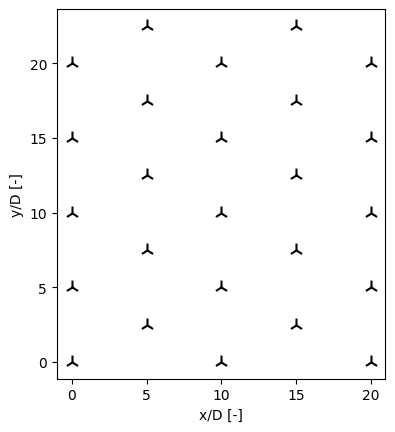

In [3]:
x, y = fm.normalized_turbine_positions
plt.scatter(x, y, c="k", marker="2", s=100)
plt.xlabel("x/D [-]")
plt.ylabel("y/D [-]")
plt.axis("scaled")
plt.show()

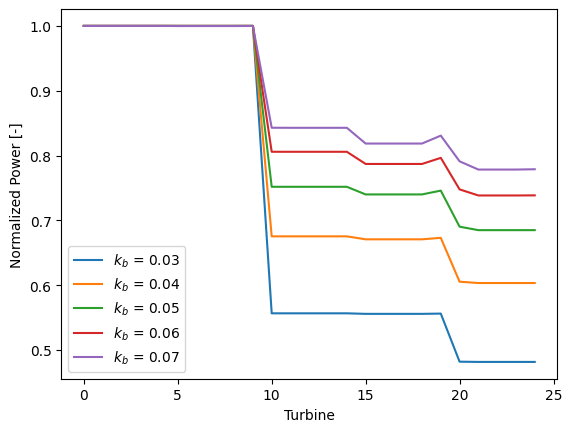

In [4]:
for k in np.linspace(0.03, 0.07, 5):
    params = umbra.ModelParams(k_b=k)
    pwr_array = fm.update_and_run(params)
    plt.plot(pwr_array[0], label=f"$k_b$ = {k:.2f}")
plt.xlabel("Turbine")
plt.ylabel("Normalized Power [-]")
plt.legend()
plt.show()

Get artificial measurements

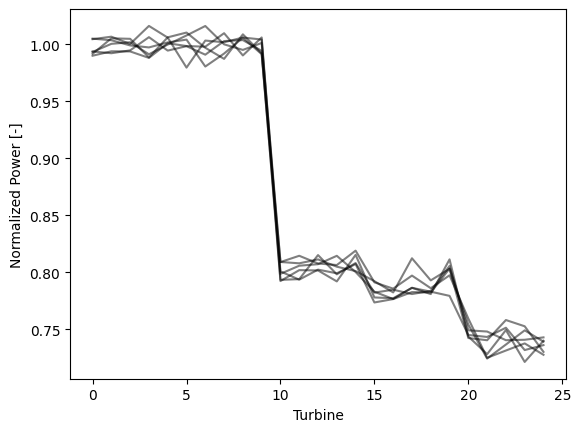

In [5]:
k_true = 0.06
sigma_true = 0.01

params = umbra.ModelParams(k_b=k_true)
pwr = fm.update_and_run(params)
data = pwr + np.random.normal(loc=0, scale=sigma_true, size=np.shape(pwr))
plt.plot(data.T, c="k", alpha=0.5)
plt.xlabel("Turbine")
plt.ylabel("Normalized Power [-]")
plt.show()

### WIFA-UQ Postprocess block

Initialize postprocessing block

In [6]:
param_dict = {"k_b": [0.02, 0.1]}
bc = BayesianCalibration(system_yaml, param_dict, data)

Fit: obtain posterior

In [7]:
samples = bc.fit()

Text(0, 0.5, 'Number of posterior samples')

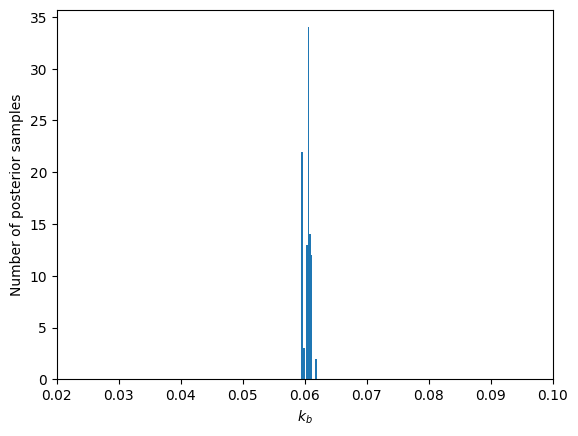

In [8]:
plt.hist(bc.samples_posterior)
plt.xlim([0.02, 0.1])
plt.xlabel("$k_b$")
plt.ylabel("Number of posterior samples")

Predict: obtain posterior predictive

In [9]:
post_pred = bc.predict()

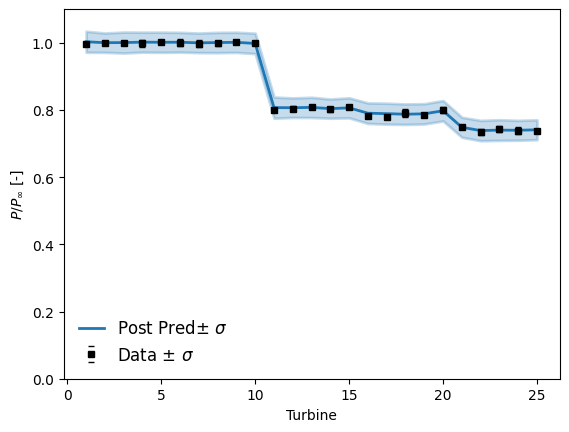

In [10]:
post_pred = bc.samples_posterior_predictive
umbra.plotting.PPC(
    np.arange(fm.nb_turbines) + 1,
    data,
    [(post_pred, "Post Pred")],
    xlabel="Turbine",
    ylabel="$P/P_\infty$ [-]",
    ylim=(0.0, 1.1),
)